<a href="https://colab.research.google.com/github/pscabral/Prezunic/blob/main/DomingoUntitled98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

In [ ]:
# Instalação do TensorFlow (descomente a linha abaixo se o TensorFlow não estiver instalado)
!pip install tensorflow

# Importação de recursos futuros do Python para compatibilidade
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Importação de bibliotecas
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

# Importações para visualização no IPython
from IPython.display import clear_output, Image, display, HTML

# Importações para aprendizado de máquina com TensorFlow e Keras
import tensorflow as tf
import tensorflow_hub as hub

# Importações adicionais
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# Importações específicas para modelos de redes neurais
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [3]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Diretórios de treinamento e teste
train_data_dir = '/content/GroceryStoreDataset/dataset/train/Fruit/'
test_data_dir = '/content/GroceryStoreDataset/dataset/test/Fruit/'

# Parâmetros
image_size = (224, 224)
batch_size = 32
epochs = 30

# Data augmentation para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Geradores de dados para treinamento e validação
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Inicialize o LabelEncoder e ajuste-o aos rótulos de classe do conjunto de treinamento
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Salve as classes em um arquivo numpy
np.save('/content/label_encoder_classes.npy', label_encoder.classes_)

# Crie o modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)

# Adicione camadas personalizadas para classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Crie o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compile o modelo
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Defina callbacks para parar o treinamento prematuramente se a validação não melhorar
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Treine o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

# Crie um gerador de dados de teste
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Avalie o modelo no conjunto de teste
eval_result = model.evaluate(test_generator)

# Exiba a precisão no conjunto de teste
print(f'Acurácia no conjunto de teste: {eval_result[1]*100:.2f}%')

# Salve o modelo treinado
model.save('classification_model.h5')

Found 920 images belonging to 19 classes.
Found 222 images belonging to 19 classes.
87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/30
29/29 [==============================] - 447s 15s/step - loss: 1.5366 - accuracy: 0.5891 - val_loss: 2.3113 - val_accuracy: 0.4820
Epoch 2/30
29/29 [==============================] - 431s 15s/step - loss: 0.3837 - accuracy: 0.9054 - val_loss: 1.9577 - val_accuracy: 0.5856
Epoch 3/30
29/29 [==============================] - 414s 14s/step - loss: 0.1552 - accuracy: 0.9674 - val_loss: 1.3720 - val_accuracy: 0.7117
Epoch 4/30
29/29 [==============================] - 431s 15s/step - loss: 0.0723 - accuracy: 0.9815 - val_loss: 0.5540 - val_accuracy: 0.8423
Epoch 5/30
29/29 [==============================] - 432s 15s/step - loss: 0.0530 - accuracy: 0.9924 - val_loss: 0.6394 - val_accuracy: 0.8514
Epoch 6/30
29/29 [==============================] - 431s 15s/step - loss: 0.0706 - accuracy: 0.9761 - val_loss: 0.4122 - val_accuracy: 0.9099

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


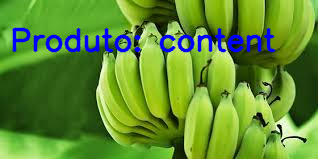

In [73]:
#!pip install gTTS
import cv2
import numpy as np
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from gtts import gTTS
import IPython.display as ipd
from google.colab.patches import cv2_imshow
import os

# Carregar o modelo treinado
model = load_model('classification_model.h5')

# Caminho para a imagem de teste (substitua pelo caminho da sua imagem)
caminho_imagem_teste = '/content/banana1.jpg'

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pelo modelo
image_resized = cv2.resize(image, (224, 224))

# Pré-processamento específico do InceptionV3
image_preprocessed = preprocess_input(np.expand_dims(image_resized, axis=0))

# Fazer a previsão usando o modelo treinado
predicted_label = model.predict(image_preprocessed)

# Obter o ID da classe prevista
predicted_class_id = np.argmax(predicted_label)

# Obter o nome da classe a partir do caminho da imagem
predicted_class = os.path.basename(os.path.dirname(caminho_imagem_teste))

# Exibir a imagem com a previsão
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, f'Produto: {predicted_class}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Gerar o arquivo de áudio com o nome do produto previsto
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')

In [74]:
class_data = np.load('/content/label_encoder_classes.npy', allow_pickle=True).item()
print(class_data)

{0: 'Golden-Delicious', 1: 'Granny-Smith', 2: 'Pink-Lady', 3: 'Red-Delicious', 4: 'Royal-Gala', 5: 'Avocado', 6: 'Banana', 7: 'Kiwi', 8: 'Lemon', 9: 'Lime', 10: 'Mango', 11: 'Cantaloupe', 12: 'Galia-Melon', 13: 'Honeydew-Melon', 14: 'Watermelon', 15: 'Nectarine', 16: 'Orange', 17: 'Papaya', 18: 'Passion-Fruit', 19: 'Peach', 20: 'Anjou', 21: 'Conference', 22: 'Kaiser', 23: 'Pineapple', 24: 'Plum', 25: 'Pomegranate', 26: 'Red-Grapefruit', 27: 'Satsumas', 28: 'Bravo-Apple-Juice', 29: 'Bravo-Orange-Juice', 30: 'God-Morgon-Apple-Juice', 31: 'God-Morgon-Orange-Juice', 32: 'God-Morgon-Orange-Red-Grapefruit-Juice', 33: 'God-Morgon-Red-Grapefruit-Juice', 34: 'Tropicana-Apple-Juice', 35: 'Tropicana-Golden-Grapefruit', 36: 'Tropicana-Juice-Smooth', 37: 'Tropicana-Mandarin-Morning', 38: 'Arla-Ecological-Medium-Fat-Milk', 39: 'Arla-Lactose-Medium-Fat-Milk', 40: 'Arla-Medium-Fat-Milk', 41: 'Arla-Standard-Milk', 42: 'Garant-Ecological-Medium-Fat-Milk', 43: 'Garant-Ecological-Standard-Milk', 44: 'Oatl

In [75]:
import numpy as np

# Especifique o nome do arquivo NPY
npy_file = 'label_encoder_classes.npy'

# Carregue o arquivo .npy usando numpy com allow_pickle=True
npy_data = np.load(npy_file, allow_pickle=True)

# Converta o numpy array para uma lista
class_data = npy_data.item()

# Agora, você pode acessar as informações do dicionário
print(class_data)

{0: 'Golden-Delicious', 1: 'Granny-Smith', 2: 'Pink-Lady', 3: 'Red-Delicious', 4: 'Royal-Gala', 5: 'Avocado', 6: 'Banana', 7: 'Kiwi', 8: 'Lemon', 9: 'Lime', 10: 'Mango', 11: 'Cantaloupe', 12: 'Galia-Melon', 13: 'Honeydew-Melon', 14: 'Watermelon', 15: 'Nectarine', 16: 'Orange', 17: 'Papaya', 18: 'Passion-Fruit', 19: 'Peach', 20: 'Anjou', 21: 'Conference', 22: 'Kaiser', 23: 'Pineapple', 24: 'Plum', 25: 'Pomegranate', 26: 'Red-Grapefruit', 27: 'Satsumas', 28: 'Bravo-Apple-Juice', 29: 'Bravo-Orange-Juice', 30: 'God-Morgon-Apple-Juice', 31: 'God-Morgon-Orange-Juice', 32: 'God-Morgon-Orange-Red-Grapefruit-Juice', 33: 'God-Morgon-Red-Grapefruit-Juice', 34: 'Tropicana-Apple-Juice', 35: 'Tropicana-Golden-Grapefruit', 36: 'Tropicana-Juice-Smooth', 37: 'Tropicana-Mandarin-Morning', 38: 'Arla-Ecological-Medium-Fat-Milk', 39: 'Arla-Lactose-Medium-Fat-Milk', 40: 'Arla-Medium-Fat-Milk', 41: 'Arla-Standard-Milk', 42: 'Garant-Ecological-Medium-Fat-Milk', 43: 'Garant-Ecological-Standard-Milk', 44: 'Oatl

In [79]:
# Salve as classes em um arquivo numpy
print("Classes:", label_encoder.classes_)
np.save('/content/label_encoder_classes.npy', label_encoder.classes_)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [81]:
import pandas as pd

# Especifique o caminho do arquivo CSV
csv_path = '/content/GroceryStoreDataset/dataset/classes.csv'

# Use o pandas para ler o arquivo CSV
df = pd.read_csv(csv_path)

# Exiba o conteúdo do DataFrame
print(df)

    Class Name (str)  Class ID (int) Coarse Class Name (str)  \
0   Golden-Delicious               0                   Apple   
1       Granny-Smith               1                   Apple   
2          Pink-Lady               2                   Apple   
3      Red-Delicious               3                   Apple   
4         Royal-Gala               4                   Apple   
..               ...             ...                     ...   
76          Red-Beet              76                Red-Beet   
77       Beef-Tomato              77                  Tomato   
78    Regular-Tomato              78                  Tomato   
79       Vine-Tomato              79                  Tomato   
80          Zucchini              80                Zucchini   

    Coarse Class ID (int)                            Iconic Image Path (str)  \
0                       0  /iconic-images-and-descriptions/Fruit/Apple/Go...   
1                       0  /iconic-images-and-descriptions/Fruit/Apple/

In [78]:
import numpy as np

# Carregue o arquivo NPY
npy_file = "/content/label_encoder_classes.npy"
npy_data = np.load(npy_file, allow_pickle=True).item()

# Imprima o conteúdo do arquivo NPY
print("Conteúdo do arquivo NPY:")
for class_id, class_name in npy_data.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

ValueError: ignored

In [77]:
import pandas as pd
import numpy as np

# Carregue o arquivo CSV
csv_file = "/content/GroceryStoreDataset/dataset/classes.csv"
df_csv = pd.read_csv(csv_file)

# Carregue o arquivo NPY
npy_file = "/content/label_encoder_classes.npy"
npy_data = np.load(npy_file, allow_pickle=True)

# Se o arquivo NPY contém um dicionário, imprima-o
if isinstance(npy_data, dict):
    # Imprima o conteúdo do arquivo CSV
    print("Conteúdo do arquivo CSV:")
    print(df_csv)

    # Imprima o conteúdo do arquivo NPY
    print("\nConteúdo do arquivo NPY:")
    print(npy_data)
else:
    print("O arquivo NPY não contém um dicionário ou não foi carregado corretamente.")

O arquivo NPY não contém um dicionário ou não foi carregado corretamente.


In [70]:
import numpy as np

# Passo 1: Crie um dicionário mapeando IDs de classe para nomes de classe
class_data = {
    0: 'Golden-Delicious',
    1: 'Granny-Smith',
    2: 'Pink-Lady',
    3: 'Red-Delicious',
    4: 'Royal-Gala',
    5: 'Avocado',
    6: 'Banana',
    7: 'Kiwi',
    8: 'Lemon',
    9: 'Lime',
    10: 'Mango',
    11: 'Cantaloupe',
    12: 'Galia-Melon',
    13: 'Honeydew-Melon',
    14: 'Watermelon',
    15: 'Nectarine',
    16: 'Orange',
    17: 'Papaya',
    18: 'Passion-Fruit',
    19: 'Peach',
    20: 'Anjou',
    21: 'Conference',
    22: 'Kaiser',
    23: 'Pineapple',
    24: 'Plum',
    25: 'Pomegranate',
    26: 'Red-Grapefruit',
    27: 'Satsumas',
    28: 'Bravo-Apple-Juice',
    29: 'Bravo-Orange-Juice',
    30: 'God-Morgon-Apple-Juice',
    31: 'God-Morgon-Orange-Juice',
    32: 'God-Morgon-Orange-Red-Grapefruit-Juice',
    33: 'God-Morgon-Red-Grapefruit-Juice',
    34: 'Tropicana-Apple-Juice',
    35: 'Tropicana-Golden-Grapefruit',
    36: 'Tropicana-Juice-Smooth',
    37: 'Tropicana-Mandarin-Morning',
    38: 'Arla-Ecological-Medium-Fat-Milk',
    39: 'Arla-Lactose-Medium-Fat-Milk',
    40: 'Arla-Medium-Fat-Milk',
    41: 'Arla-Standard-Milk',
    42: 'Garant-Ecological-Medium-Fat-Milk',
    43: 'Garant-Ecological-Standard-Milk',
    44: 'Oatly-Natural-Oatghurt',
    45: 'Oatly-Oat-Milk',
    46: 'Arla-Ecological-Sour-Cream',
    47: 'Arla-Sour-Cream',
    48: 'Arla-Sour-Milk',
    49: 'Alpro-Blueberry-Soyghurt',
    50: 'Alpro-Vanilla-Soyghurt',
    51: 'Alpro-Fresh-Soy-Milk',
    52: 'Alpro-Shelf-Soy-Milk',
    53: 'Arla-Mild-Vanilla-Yoghurt',
    54: 'Arla-Natural-Mild-Low-Fat-Yoghurt',
    55: 'Arla-Natural-Yoghurt',
    56: 'Valio-Vanilla-Yoghurt',
    57: 'Yoggi-Strawberry-Yoghurt',
    58: 'Yoggi-Vanilla-Yoghurt',
    59: 'Asparagus',
    60: 'Aubergine',
    61: 'Cabbage',
    62: 'Carrots',
    63: 'Cucumber',
    64: 'Garlic',
    65: 'Ginger',
    66: 'Leek',
    67: 'Brown-Cap-Mushroom',
    68: 'Yellow-Onion',
    69: 'Green-Bell-Pepper',
    70: 'Orange-Bell-Pepper',
    71: 'Red-Bell-Pepper',
    72: 'Yellow-Bell-Pepper',
    73: 'Floury-Potato',
    74: 'Solid-Potato',
    75: 'Sweet-Potato',
    76: 'Red-Beet',
    77: 'Beef-Tomato',
    78: 'Regular-Tomato',
    79: 'Vine-Tomato',
    80: 'Zucchini',
}

# Passo 2: Salve o dicionário em um arquivo NPY
np.save('label_encoder_classes.npy', class_data)